In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention,CrossAttention
import sys,os
from sklearn.model_selection import KFold
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf300 = pd.read_json('evaluation_set/deepnofakes/dnf_300/combined_300.json').T
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V2.json')
dnf_eval.columns = ['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf300.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type',
        'urls'],
       dtype='object'),
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'type', 'urls'], dtype='object'),
 300,
 300)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 0
for idx in articles.keys():
    num = len(articles[idx])
    if num>=max_sentences:
        max_sentences = num
        
max_sentences

35

In [5]:
dnf_eval.headline.unique().shape

(50,)

In [6]:
dnf_eval.drop(columns=['claims'])

,authors,evidence,headline,id,reason,type,urls
0,Bushord Washington,[https://www.snopes.com/fact-check/wikileaks-cofirms-hillary-clinton-sold-weapons-to-isis/],WikiLeaks CONFIRMS Hillary Sold Weapons to ISIS... Then Drops Another BOMBSHELL! Breaking News,0,Based on Snopes rating 'Mixture' which means 'a claim has significant elements of both truth and falsity to it such that it could not fairly be described by any other rating.',1,http://thefederalistpapers.org/us/wikileaks-claim-hillary-gave-weapons-to-isis
1,Mike Adams,[https://www.snopes.com/fact-check/clinton-secret-earpiece-debate/],Hillary Clinton Wore Secret Earpiece During First Presidential Debate?,1,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,http://www.naturalnews.com/055233_ear_piece_Hillary_Clinton_presidential_debate.html
2,the Burrard Street Journal,"[https://www.snopes.com/fact-check/obama-confirms-he-will-refuse-to-leave-office/, https://www.truthorfiction.com/president-obama-will-refuse-leave-office-trump-elected/]",President Obama Confirms He Will Refuse to Leave Office If Trump Is Elected,2,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,http://www.burrardstreetjournal.com/obama-refusing-to-leave-if-trump-elected/
3,admin,"[https://www.snopes.com/fact-check/clinton-votes-found-in-warehouse/, https://local12.com/news/local/ohio-secretary-of-state-debunks-false-story-about-fake-clinton-votes, https://www.truthorfiction.com/thousands-of-fraudulent-clinton-votes-found-in-ohio-warehouse/]",BREAKING: Fraudulent Clinton Votes Discovered By The “Tens Of Thousands”,3,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,https://www.usasupreme.com/fbi-director-received-millions-clinton-foundation-brothers-law-firm-clintons-taxes/
4,Alex D.,[https://www.snopes.com/fact-check/comey-clinton-foundation/],"FBI director received millions from Clinton Foundation, his brother’s law firm does Clinton’s taxes",4,"Based on Snopes rating 'Unproven' which means 'insufficient evidence exists to establish the given claim as true, but the claim cannot be definitively proved false.'",1,https://www.usasupreme.com/fbi-director-received-millions-clinton-foundation-brothers-law-firm-clintons-taxes/
5,Paul Joseph Watson,"[https://www.snopes.com/fact-check/hillary-clinton-secret-earpiece/, https://www.snopes.com/fact-check/clinton-secret-earpiece-debate/]",Hillary Clinton Wore 'Secret Earpiece' During Commander-in-Chief Forum,5,"The key claim is false (based on Snopes rating), however, the article also contains opinions stated as fact.",2,http://www.infowars.com/was-hillary-wearing-an-earpiece-during-last-nights-presidential-forum/
6,Baltimore Gazette,"[https://www.snopes.com/fact-check/clinton-received-debate-questions-week-before-debate/, https://www.truthorfiction.com/hillary-clinton-received-debate-questions-advance/]",Clinton Received Debate Questions Week Before Debate,6,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,http://www.freemarketcentral.com/index.php/post/2503/report-clinton-received-debate-questions-a-week-before-debate
7,Jim Hoft,[https://www.snopes.com/fact-check/debate-secret-hand-signals/],Hillary Clinton Used Hand Signals to Rig Debate?,7,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,http://www.thegatewaypundit.com/2016/09/breaking-poker-pro-agrees-hillary-sending-hand-signals-debate-moderator-holt/
8,Alex Griswold,[https://www.snopes.com/fact-check/hillary-clinton-donations-clinton-foundation/],Hillary Clinton Cut Her Tax Bill by 'Donating' $1 Million to Herself via the Clinton Foundation?,8,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,http://www.mediaite.com/election-2016/96-of-the-clintons-2015-charitable-donations-were-to-the-clinton-fou

In [7]:
dnf300.sort_values(by='id')

,authors,evidence,headline,id,reason,type,urls
0,Bushord Washington,[https://www.snopes.com/fact-check/wikileaks-cofirms-hillary-clinton-sold-weapons-to-isis/],WikiLeaks CONFIRMS Hillary Sold Weapons to ISIS... Then Drops Another BOMBSHELL! Breaking News,0,Based on Snopes rating 'Mixture' which means 'a claim has significant elements of both truth and falsity to it such that it could not fairly be described by any other rating.',1,http://thefederalistpapers.org/us/wikileaks-claim-hillary-gave-weapons-to-isis
1,Mike Adams,[https://www.snopes.com/fact-check/clinton-secret-earpiece-debate/],Hillary Clinton Wore Secret Earpiece During First Presidential Debate?,1,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,http://www.naturalnews.com/055233_ear_piece_Hillary_Clinton_presidential_debate.html
2,the Burrard Street Journal,"[https://www.snopes.com/fact-check/obama-confirms-he-will-refuse-to-leave-office/, https://www.truthorfiction.com/president-obama-will-refuse-leave-office-trump-elected/]",President Obama Confirms He Will Refuse to Leave Office If Trump Is Elected,2,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,http://www.burrardstreetjournal.com/obama-refusing-to-leave-if-trump-elected/
3,admin,"[https://www.snopes.com/fact-check/clinton-votes-found-in-warehouse/, https://local12.com/news/local/ohio-secretary-of-state-debunks-false-story-about-fake-clinton-votes, https://www.truthorfiction.com/thousands-of-fraudulent-clinton-votes-found-in-ohio-warehouse/]",BREAKING: Fraudulent Clinton Votes Discovered By The “Tens Of Thousands”,3,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,https://www.usasupreme.com/fbi-director-received-millions-clinton-foundation-brothers-law-firm-clintons-taxes/
4,Alex D.,[https://www.snopes.com/fact-check/comey-clinton-foundation/],"FBI director received millions from Clinton Foundation, his brother’s law firm does Clinton’s taxes",4,"Based on Snopes rating 'Unproven' which means 'insufficient evidence exists to establish the given claim as true, but the claim cannot be definitively proved false.'",1,https://www.usasupreme.com/fbi-director-received-millions-clinton-foundation-brothers-law-firm-clintons-taxes/
5,Paul Joseph Watson,"[https://www.snopes.com/fact-check/hillary-clinton-secret-earpiece/, https://www.snopes.com/fact-check/clinton-secret-earpiece-debate/]",Hillary Clinton Wore 'Secret Earpiece' During Commander-in-Chief Forum,5,"The key claim is false (based on Snopes rating), however, the article also contains opinions stated as fact.",2,http://www.infowars.com/was-hillary-wearing-an-earpiece-during-last-nights-presidential-forum/
6,Baltimore Gazette,"[https://www.snopes.com/fact-check/clinton-received-debate-questions-week-before-debate/, https://www.truthorfiction.com/hillary-clinton-received-debate-questions-advance/]",Clinton Received Debate Questions Week Before Debate,6,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,http://www.freemarketcentral.com/index.php/post/2503/report-clinton-received-debate-questions-a-week-before-debate
7,Jim Hoft,[https://www.snopes.com/fact-check/debate-secret-hand-signals/],Hillary Clinton Used Hand Signals to Rig Debate?,7,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,http://www.thegatewaypundit.com/2016/09/breaking-poker-pro-agrees-hillary-sending-hand-signals-debate-moderator-holt/
8,Alex Griswold,[https://www.snopes.com/fact-check/hillary-clinton-donations-clinton-foundation/],Hillary Clinton Cut Her Tax Bill by 'Donating' $1 Million to Herself via the Clinton Foundation?,8,Based on Snopes rating 'False' which means 'the primary elements of a claim are demonstrably false.',0,http://www.mediaite.com/election-2016/96-of-the-clintons-2015-charitable-donations-were-to-the-clinton-fou

In [8]:
titles = sorted(dnf300.headline.unique())
len(titles)

300

In [77]:
dnf_eval[dnf_eval.headline==idx]['claims'].values[0]

SyntaxError: unexpected EOF while parsing (<ipython-input-77-d115b002b68a>, line 1)

In [9]:
test_titles = sorted(dnf_eval.headline.unique())

In [10]:
titles = sorted(dnf300.headline.unique())
non_test_titles = np.array(list(set(titles)-set(test_titles)))


In [11]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [12]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249] [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 

(200, 50, 50)

In [13]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [78]:
def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        try:
            hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
            hds.append(hd)
            ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
        except Exception as ex:
            print(idx)
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        ar_claims.append(cl)
        sentences=articles[ar_id]
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        vectors = article_vectors[ar_id]
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [79]:
tdg = datagen_dnf(train_batchsize,dnf300,mode='train')
vdg = datagen_dnf(val_batchsize,dnf300,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf300,mode='test')

In [80]:
x,y = next(test_dg)

In [81]:
x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

((50, 35, 300), (50, 300), (50, 50, 20000))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 35, 300)      0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 35, 16)       14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 35, 16)       0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 35, 32)       1568        dropout_7[0][0]                  
__________________________________________________________________________________________________
dropout_8 

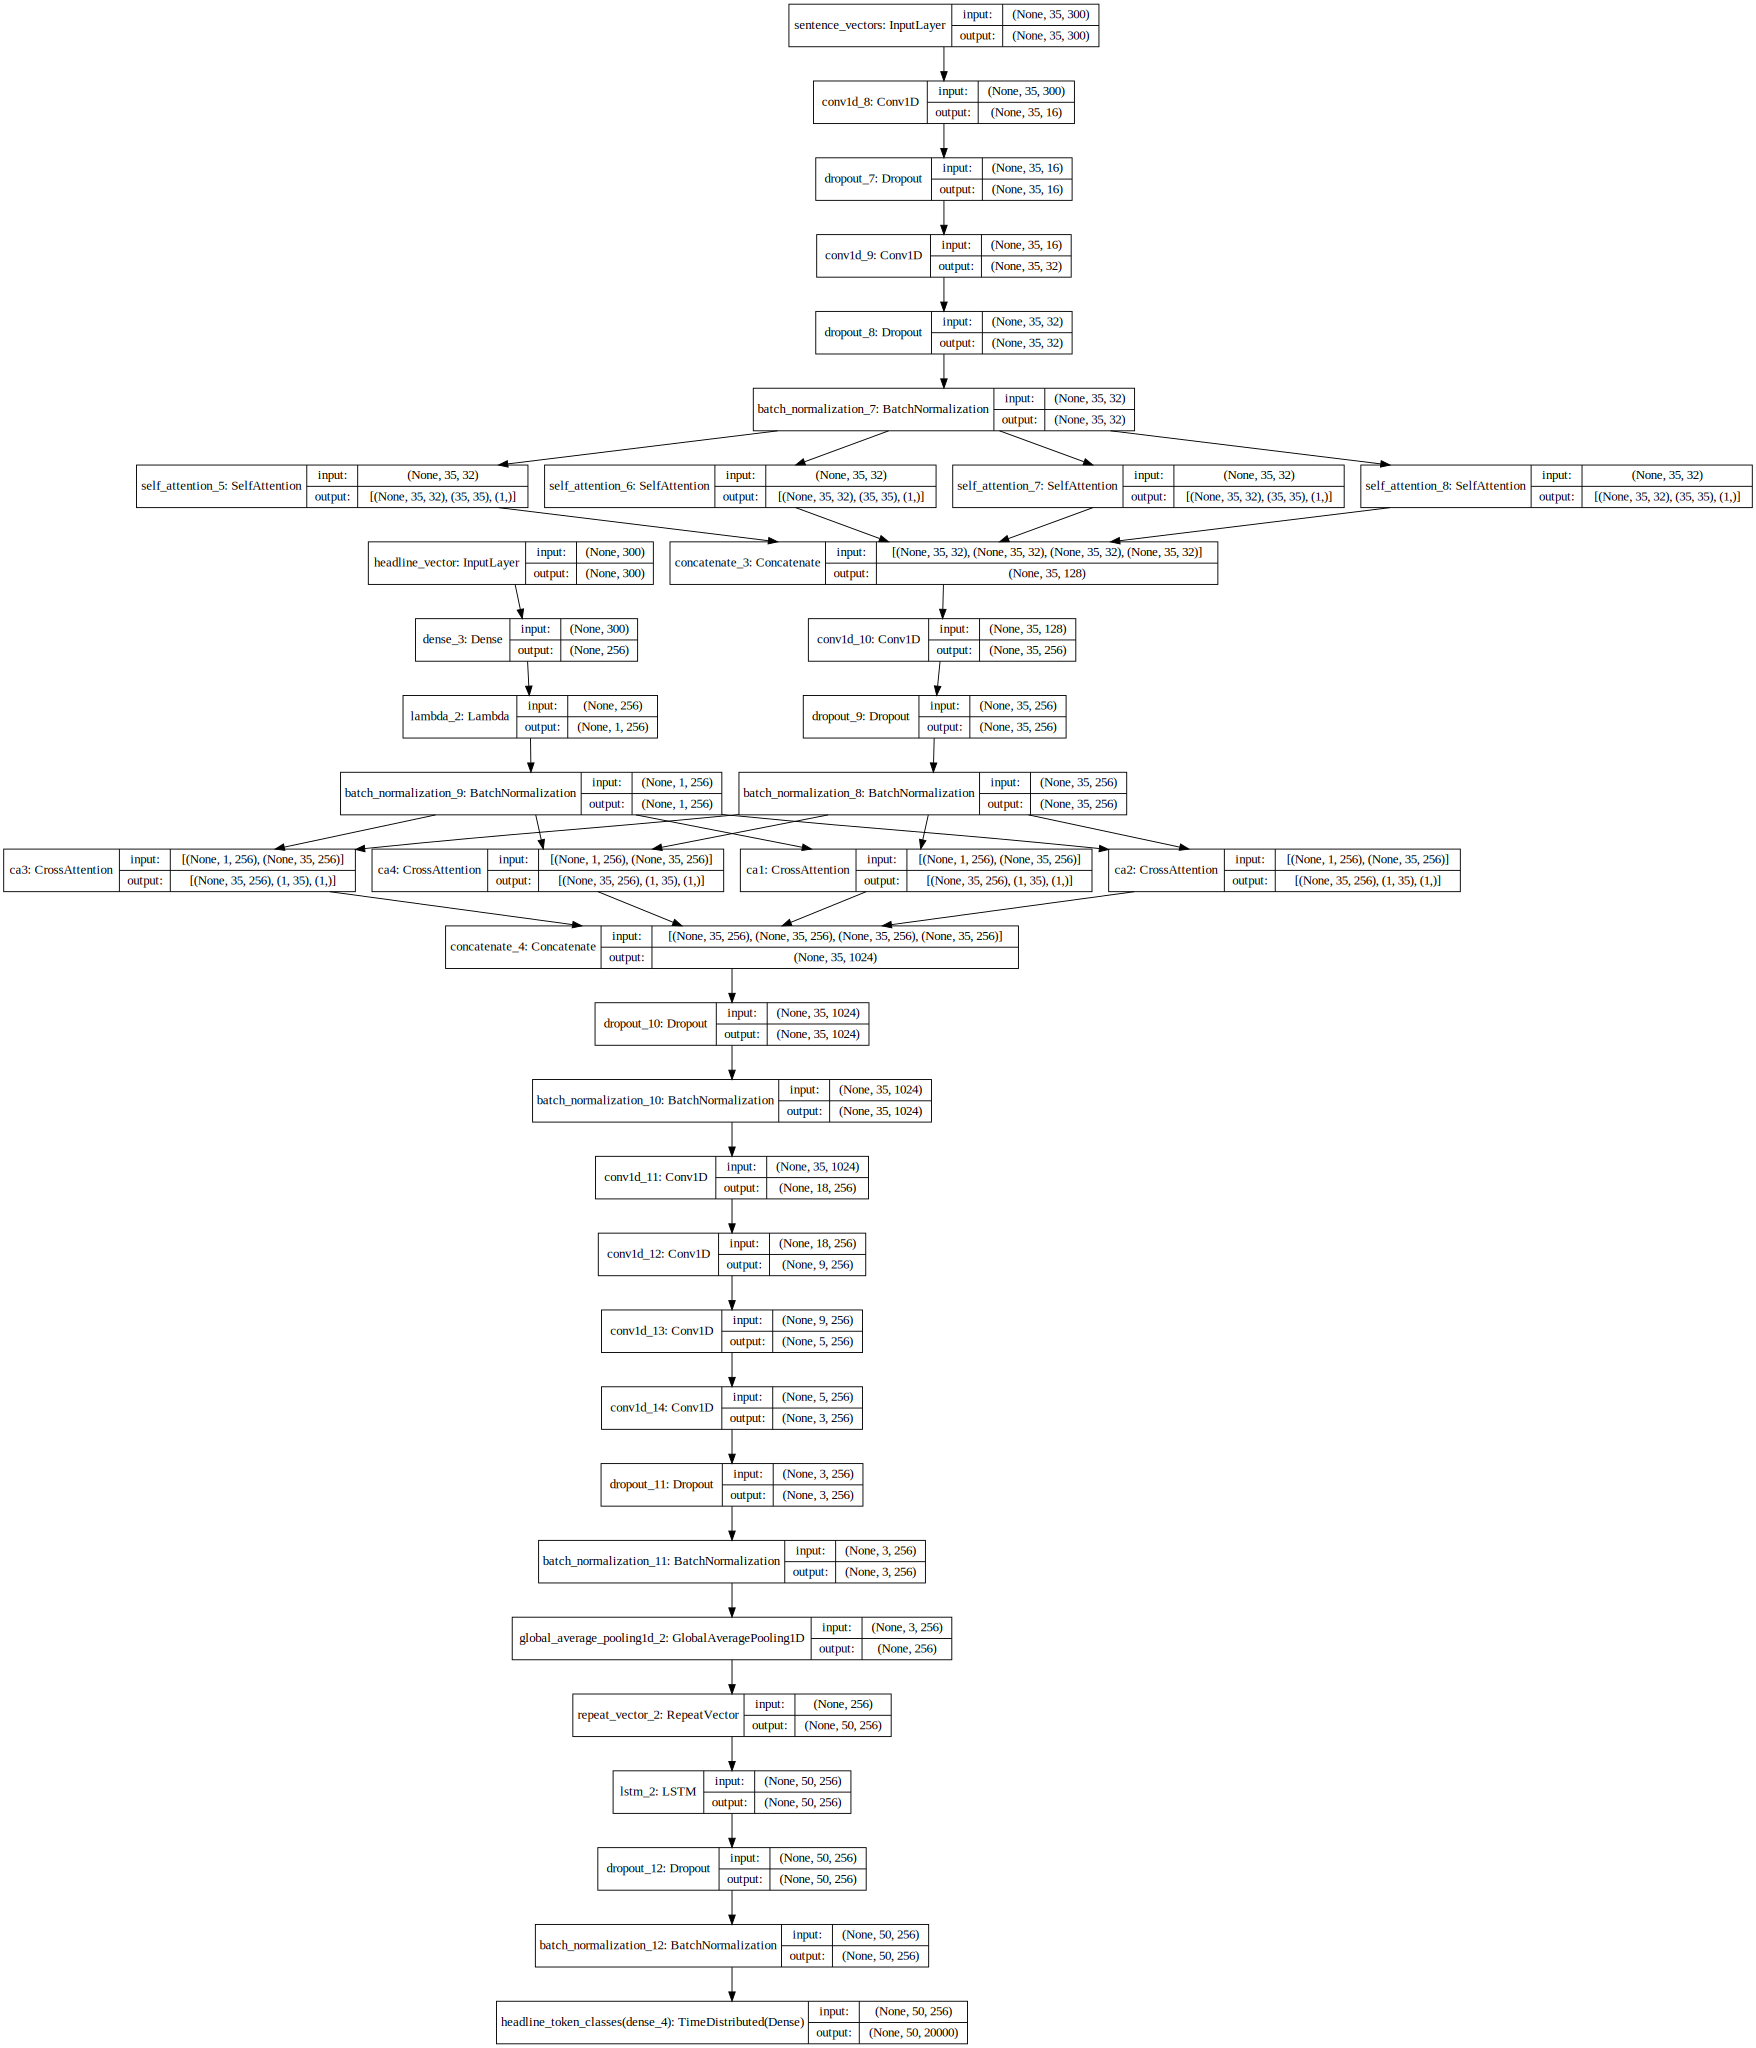

In [50]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]))(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
    repeat = RepeatVector(50)(gap)
    lstm1 = LSTM(256,return_sequences=True, activation='relu')(repeat)
    lstm1 = Dropout(0.5)(lstm1)
    lstm1 = BatchNormalization()(lstm1)
    gen_hd_vector = TimeDistributed(Dense(20000,activation='softmax'), name='headline_token_classes')(lstm1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [19]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf300_sa_sent_hd_word.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf300_sa_sent_hd_word/{0}'.format(dt.timestamp()),write_graph=True)

In [20]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 9s 2s/step - loss: 9.9124 - acc: 3.1250e-04 - val_loss: 9.8807 - val_acc: 0.0000e+00
Epoch 2/2000
4/4 [==============================] - 1s 168ms/step - loss: 9.9063 - acc: 0.0000e+00 - val_loss: 9.8883 - val_acc: 0.0000e+00
Epoch 3/2000
4/4 [==============================] - 1s 208ms/step - loss: 9.8990 - acc: 3.1250e-04 - val_loss: 9.8859 - val_acc: 0.0000e+00
Epoch 4/2000
4/4 [==============================] - 1s 216ms/step - loss: 9.8914 - acc: 0.0014 - val_loss: 9.8868 - val_acc: 0.0000e+00
Epoch 5/2000
4/4 [==============================] - 1s 347ms/step - loss: 9.8797 - acc: 0.0030 - val_loss: 9.8764 - val_acc: 0.0000e+00
Epoch 6/2000
4/4 [==============================] - 2s 432ms/step - loss: 9.8707 - acc: 0.0081 - val_loss: 9.8659 - val_acc: 0.0000e+00
Epoch 7/2000
4/4 [==============================] - 2s 419ms/step - loss: 9.8604 - acc: 0.0131 - val_loss: 9.8444 - val_acc: 0.0000e+00
Epoch 8/2000
4/4 [=====================

4/4 [==============================] - 2s 437ms/step - loss: 9.1869 - acc: 0.3723 - val_loss: 8.8202 - val_acc: 0.7519
Epoch 63/2000
4/4 [==============================] - 2s 439ms/step - loss: 9.1629 - acc: 0.3941 - val_loss: 8.8104 - val_acc: 0.7469
Epoch 64/2000
4/4 [==============================] - 2s 430ms/step - loss: 9.1683 - acc: 0.3981 - val_loss: 8.6051 - val_acc: 0.7556
Epoch 65/2000
4/4 [==============================] - 2s 428ms/step - loss: 9.1239 - acc: 0.3959 - val_loss: 8.5667 - val_acc: 0.7244
Epoch 66/2000
4/4 [==============================] - 2s 434ms/step - loss: 9.1049 - acc: 0.3916 - val_loss: 8.5217 - val_acc: 0.7613
Epoch 67/2000
4/4 [==============================] - 2s 434ms/step - loss: 9.0853 - acc: 0.4169 - val_loss: 7.9366 - val_acc: 0.7331
Epoch 68/2000
4/4 [==============================] - 2s 437ms/step - loss: 9.0861 - acc: 0.4084 - val_loss: 8.3461 - val_acc: 0.7462
Epoch 69/2000
4/4 [==============================] - 2s 445ms/step - loss: 9.0436 -

4/4 [==============================] - 2s 445ms/step - loss: 7.9321 - acc: 0.5261 - val_loss: 7.7389 - val_acc: 0.7387
Epoch 124/2000
4/4 [==============================] - 2s 437ms/step - loss: 7.9288 - acc: 0.5594 - val_loss: 7.7120 - val_acc: 0.7156
Epoch 125/2000
4/4 [==============================] - 2s 444ms/step - loss: 7.9021 - acc: 0.5288 - val_loss: 7.6673 - val_acc: 0.7362
Epoch 126/2000
4/4 [==============================] - 2s 437ms/step - loss: 7.8875 - acc: 0.5339 - val_loss: 7.6471 - val_acc: 0.7281
Epoch 127/2000
4/4 [==============================] - 2s 450ms/step - loss: 7.9331 - acc: 0.5541 - val_loss: 7.6183 - val_acc: 0.7231
Epoch 128/2000
4/4 [==============================] - 2s 440ms/step - loss: 7.8355 - acc: 0.5470 - val_loss: 7.5133 - val_acc: 0.7381
Epoch 129/2000
4/4 [==============================] - 2s 438ms/step - loss: 7.8511 - acc: 0.5558 - val_loss: 7.4693 - val_acc: 0.7425
Epoch 130/2000
4/4 [==============================] - 2s 437ms/step - loss: 7

4/4 [==============================] - 2s 442ms/step - loss: 6.5880 - acc: 0.6747 - val_loss: 6.5580 - val_acc: 0.7400
Epoch 185/2000
4/4 [==============================] - 2s 428ms/step - loss: 6.6658 - acc: 0.6859 - val_loss: 6.7060 - val_acc: 0.7188
Epoch 186/2000
4/4 [==============================] - 2s 438ms/step - loss: 6.5435 - acc: 0.6773 - val_loss: 6.9680 - val_acc: 0.7375
Epoch 187/2000
4/4 [==============================] - 2s 450ms/step - loss: 6.5341 - acc: 0.6683 - val_loss: 6.8884 - val_acc: 0.7462
Epoch 188/2000
4/4 [==============================] - 2s 428ms/step - loss: 6.5128 - acc: 0.6919 - val_loss: 6.8071 - val_acc: 0.7656
Epoch 189/2000
4/4 [==============================] - 2s 440ms/step - loss: 6.5359 - acc: 0.6666 - val_loss: 7.1774 - val_acc: 0.7481
Epoch 190/2000
4/4 [==============================] - 2s 431ms/step - loss: 6.5100 - acc: 0.6661 - val_loss: 7.1241 - val_acc: 0.7400
Epoch 191/2000
4/4 [==============================] - 2s 434ms/step - loss: 6

4/4 [==============================] - 2s 427ms/step - loss: 5.1281 - acc: 0.7033 - val_loss: 5.2522 - val_acc: 0.7600
Epoch 246/2000
4/4 [==============================] - 2s 432ms/step - loss: 5.0721 - acc: 0.7042 - val_loss: 5.2873 - val_acc: 0.7431
Epoch 247/2000
4/4 [==============================] - 2s 445ms/step - loss: 5.1005 - acc: 0.7006 - val_loss: 5.3188 - val_acc: 0.7256
Epoch 248/2000
4/4 [==============================] - 2s 449ms/step - loss: 5.0120 - acc: 0.7080 - val_loss: 5.2503 - val_acc: 0.7300
Epoch 249/2000
4/4 [==============================] - 2s 414ms/step - loss: 4.9475 - acc: 0.7111 - val_loss: 5.2328 - val_acc: 0.7375
Epoch 250/2000
4/4 [==============================] - 2s 433ms/step - loss: 4.9973 - acc: 0.7105 - val_loss: 5.1073 - val_acc: 0.7631
Epoch 251/2000
4/4 [==============================] - 2s 416ms/step - loss: 4.9175 - acc: 0.7155 - val_loss: 5.1766 - val_acc: 0.7331
Epoch 252/2000
4/4 [==============================] - 2s 433ms/step - loss: 4

4/4 [==============================] - 2s 427ms/step - loss: 3.8404 - acc: 0.7245 - val_loss: 3.3412 - val_acc: 0.7625
Epoch 307/2000
4/4 [==============================] - 2s 414ms/step - loss: 3.8594 - acc: 0.7281 - val_loss: 3.3733 - val_acc: 0.7556
Epoch 308/2000
4/4 [==============================] - 2s 451ms/step - loss: 3.8688 - acc: 0.7295 - val_loss: 3.3656 - val_acc: 0.7406
Epoch 309/2000
4/4 [==============================] - 2s 445ms/step - loss: 3.7671 - acc: 0.7191 - val_loss: 3.4193 - val_acc: 0.7281
Epoch 310/2000
4/4 [==============================] - 2s 443ms/step - loss: 3.8228 - acc: 0.7314 - val_loss: 3.2571 - val_acc: 0.7575
Epoch 311/2000
4/4 [==============================] - 2s 410ms/step - loss: 3.7613 - acc: 0.7262 - val_loss: 3.3033 - val_acc: 0.7431
Epoch 312/2000
4/4 [==============================] - 2s 444ms/step - loss: 3.7438 - acc: 0.7452 - val_loss: 3.2422 - val_acc: 0.7437
Epoch 313/2000
4/4 [==============================] - 2s 436ms/step - loss: 3

4/4 [==============================] - 2s 444ms/step - loss: 2.9308 - acc: 0.7303 - val_loss: 2.4587 - val_acc: 0.7387
Epoch 368/2000
4/4 [==============================] - 2s 430ms/step - loss: 2.7907 - acc: 0.7441 - val_loss: 2.3323 - val_acc: 0.7581
Epoch 369/2000
4/4 [==============================] - 2s 445ms/step - loss: 2.6357 - acc: 0.7631 - val_loss: 2.4410 - val_acc: 0.7456
Epoch 370/2000
4/4 [==============================] - 2s 451ms/step - loss: 2.9251 - acc: 0.7336 - val_loss: 2.3919 - val_acc: 0.7481
Epoch 371/2000
4/4 [==============================] - 2s 421ms/step - loss: 2.7566 - acc: 0.7447 - val_loss: 2.2177 - val_acc: 0.7688
Epoch 372/2000
4/4 [==============================] - 2s 417ms/step - loss: 2.8420 - acc: 0.7344 - val_loss: 2.1598 - val_acc: 0.7788
Epoch 373/2000
4/4 [==============================] - 2s 439ms/step - loss: 2.8708 - acc: 0.7294 - val_loss: 2.4339 - val_acc: 0.7406
Epoch 374/2000
4/4 [==============================] - 2s 437ms/step - loss: 2

4/4 [==============================] - 2s 407ms/step - loss: 2.4156 - acc: 0.7331 - val_loss: 2.0173 - val_acc: 0.7638
Epoch 429/2000
4/4 [==============================] - 2s 438ms/step - loss: 2.2011 - acc: 0.7516 - val_loss: 2.0749 - val_acc: 0.7625
Epoch 430/2000
4/4 [==============================] - 2s 448ms/step - loss: 2.2499 - acc: 0.7442 - val_loss: 2.0234 - val_acc: 0.7656
Epoch 431/2000
4/4 [==============================] - 2s 432ms/step - loss: 2.2154 - acc: 0.7511 - val_loss: 2.0934 - val_acc: 0.7569
Epoch 432/2000
4/4 [==============================] - 2s 457ms/step - loss: 2.3986 - acc: 0.7203 - val_loss: 2.1128 - val_acc: 0.7588
Epoch 433/2000
4/4 [==============================] - 2s 435ms/step - loss: 2.2130 - acc: 0.7512 - val_loss: 2.0292 - val_acc: 0.7631
Epoch 434/2000
4/4 [==============================] - 2s 439ms/step - loss: 2.2791 - acc: 0.7427 - val_loss: 2.1663 - val_acc: 0.7462
Epoch 435/2000
4/4 [==============================] - 2s 444ms/step - loss: 2

4/4 [==============================] - 2s 426ms/step - loss: 1.9551 - acc: 0.7603 - val_loss: 1.8493 - val_acc: 0.7881
Epoch 490/2000
4/4 [==============================] - 2s 411ms/step - loss: 2.1245 - acc: 0.7336 - val_loss: 2.2145 - val_acc: 0.7437
Epoch 491/2000
4/4 [==============================] - 2s 426ms/step - loss: 1.9993 - acc: 0.7500 - val_loss: 2.1893 - val_acc: 0.7450
Epoch 492/2000
4/4 [==============================] - 2s 442ms/step - loss: 1.9528 - acc: 0.7537 - val_loss: 2.2170 - val_acc: 0.7419
Epoch 493/2000
4/4 [==============================] - 2s 433ms/step - loss: 2.0153 - acc: 0.7523 - val_loss: 2.3865 - val_acc: 0.7319
Epoch 494/2000
4/4 [==============================] - 2s 439ms/step - loss: 1.9874 - acc: 0.7475 - val_loss: 2.1909 - val_acc: 0.7613
Epoch 495/2000
4/4 [==============================] - 2s 436ms/step - loss: 2.0235 - acc: 0.7473 - val_loss: 2.1675 - val_acc: 0.7606
Epoch 496/2000
4/4 [==============================] - 2s 428ms/step - loss: 1

4/4 [==============================] - 2s 409ms/step - loss: 1.9593 - acc: 0.7395 - val_loss: 2.5266 - val_acc: 0.7312
Epoch 551/2000
4/4 [==============================] - 2s 438ms/step - loss: 1.9019 - acc: 0.7523 - val_loss: 2.2849 - val_acc: 0.7581
Epoch 552/2000
4/4 [==============================] - 2s 435ms/step - loss: 1.9233 - acc: 0.7489 - val_loss: 2.1068 - val_acc: 0.7575
Epoch 553/2000
4/4 [==============================] - 2s 429ms/step - loss: 1.9311 - acc: 0.7466 - val_loss: 2.1413 - val_acc: 0.7625
Epoch 554/2000
4/4 [==============================] - 2s 427ms/step - loss: 2.0077 - acc: 0.7442 - val_loss: 2.0078 - val_acc: 0.7681
Epoch 555/2000
4/4 [==============================] - 2s 439ms/step - loss: 2.0078 - acc: 0.7397 - val_loss: 2.1395 - val_acc: 0.7625
Epoch 556/2000
4/4 [==============================] - 2s 437ms/step - loss: 1.8212 - acc: 0.7583 - val_loss: 2.1738 - val_acc: 0.7538
Epoch 557/2000
4/4 [==============================] - 2s 440ms/step - loss: 1

4/4 [==============================] - 2s 436ms/step - loss: 1.9099 - acc: 0.7467 - val_loss: 2.1899 - val_acc: 0.7469
Epoch 612/2000
4/4 [==============================] - 2s 439ms/step - loss: 1.8736 - acc: 0.7495 - val_loss: 2.4609 - val_acc: 0.7287
Epoch 613/2000
4/4 [==============================] - 2s 428ms/step - loss: 1.7105 - acc: 0.7641 - val_loss: 2.1749 - val_acc: 0.7487
Epoch 614/2000
4/4 [==============================] - 2s 428ms/step - loss: 1.8659 - acc: 0.7512 - val_loss: 2.2212 - val_acc: 0.7569
Epoch 615/2000
4/4 [==============================] - 2s 437ms/step - loss: 1.9163 - acc: 0.7387 - val_loss: 2.2052 - val_acc: 0.7575
Epoch 616/2000
4/4 [==============================] - 2s 417ms/step - loss: 1.8443 - acc: 0.7486 - val_loss: 2.4906 - val_acc: 0.7294
Epoch 617/2000
4/4 [==============================] - 2s 431ms/step - loss: 1.8194 - acc: 0.7545 - val_loss: 2.2738 - val_acc: 0.7325
Epoch 618/2000
4/4 [==============================] - 2s 435ms/step - loss: 1

4/4 [==============================] - 2s 428ms/step - loss: 1.8087 - acc: 0.7456 - val_loss: 2.4357 - val_acc: 0.7356
Epoch 673/2000
4/4 [==============================] - 2s 426ms/step - loss: 1.7889 - acc: 0.7520 - val_loss: 2.2699 - val_acc: 0.7575
Epoch 674/2000
4/4 [==============================] - 2s 442ms/step - loss: 1.8218 - acc: 0.7486 - val_loss: 2.3525 - val_acc: 0.7475
Epoch 675/2000
4/4 [==============================] - 2s 431ms/step - loss: 1.7962 - acc: 0.7511 - val_loss: 2.3396 - val_acc: 0.7450
Epoch 676/2000
4/4 [==============================] - 2s 430ms/step - loss: 1.7712 - acc: 0.7503 - val_loss: 2.6552 - val_acc: 0.7212
Epoch 677/2000
4/4 [==============================] - 2s 440ms/step - loss: 1.7524 - acc: 0.7522 - val_loss: 2.4117 - val_acc: 0.7387
Epoch 678/2000
4/4 [==============================] - 2s 431ms/step - loss: 1.7805 - acc: 0.7516 - val_loss: 2.3587 - val_acc: 0.7425
Epoch 679/2000
4/4 [==============================] - 2s 432ms/step - loss: 1

4/4 [==============================] - 2s 460ms/step - loss: 1.8065 - acc: 0.7459 - val_loss: 2.3757 - val_acc: 0.7481
Epoch 734/2000
4/4 [==============================] - 2s 433ms/step - loss: 1.8388 - acc: 0.7495 - val_loss: 2.5301 - val_acc: 0.7394
Epoch 735/2000
4/4 [==============================] - 2s 437ms/step - loss: 1.7992 - acc: 0.7534 - val_loss: 2.5886 - val_acc: 0.7344
Epoch 736/2000
4/4 [==============================] - 2s 439ms/step - loss: 1.8796 - acc: 0.7456 - val_loss: 2.5472 - val_acc: 0.7319
Epoch 737/2000
4/4 [==============================] - 2s 433ms/step - loss: 1.8781 - acc: 0.7447 - val_loss: 2.7244 - val_acc: 0.7225
Epoch 738/2000
4/4 [==============================] - 2s 443ms/step - loss: 1.7688 - acc: 0.7573 - val_loss: 2.4962 - val_acc: 0.7469
Epoch 739/2000
4/4 [==============================] - 2s 438ms/step - loss: 1.8604 - acc: 0.7439 - val_loss: 2.4003 - val_acc: 0.7538
Epoch 740/2000
4/4 [==============================] - 2s 430ms/step - loss: 1

4/4 [==============================] - 2s 438ms/step - loss: 1.8126 - acc: 0.7425 - val_loss: 2.5024 - val_acc: 0.7375
Epoch 795/2000
4/4 [==============================] - 2s 424ms/step - loss: 1.8136 - acc: 0.7455 - val_loss: 2.2806 - val_acc: 0.7538
Epoch 796/2000
4/4 [==============================] - 2s 446ms/step - loss: 1.9230 - acc: 0.7306 - val_loss: 2.5667 - val_acc: 0.7400
Epoch 797/2000
4/4 [==============================] - 2s 436ms/step - loss: 1.8962 - acc: 0.7403 - val_loss: 2.5768 - val_acc: 0.7306
Epoch 798/2000
4/4 [==============================] - 2s 428ms/step - loss: 1.7623 - acc: 0.7480 - val_loss: 2.6005 - val_acc: 0.7425
Epoch 799/2000
4/4 [==============================] - 2s 441ms/step - loss: 1.8137 - acc: 0.7420 - val_loss: 2.6099 - val_acc: 0.7287
Epoch 800/2000
4/4 [==============================] - 2s 432ms/step - loss: 1.8049 - acc: 0.7455 - val_loss: 2.4894 - val_acc: 0.7456
Epoch 801/2000
4/4 [==============================] - 2s 442ms/step - loss: 1

4/4 [==============================] - 2s 616ms/step - loss: 1.7977 - acc: 0.7442 - val_loss: 2.4644 - val_acc: 0.7419
Epoch 856/2000
4/4 [==============================] - 3s 721ms/step - loss: 1.6105 - acc: 0.7644 - val_loss: 2.4986 - val_acc: 0.7344
Epoch 857/2000
4/4 [==============================] - 3s 637ms/step - loss: 1.7518 - acc: 0.7452 - val_loss: 2.5161 - val_acc: 0.7250
Epoch 858/2000
4/4 [==============================] - 3s 677ms/step - loss: 1.7529 - acc: 0.7528 - val_loss: 2.5910 - val_acc: 0.7344
Epoch 859/2000
4/4 [==============================] - 3s 800ms/step - loss: 1.7241 - acc: 0.7523 - val_loss: 2.3195 - val_acc: 0.7487
Epoch 860/2000
4/4 [==============================] - 3s 659ms/step - loss: 1.8114 - acc: 0.7391 - val_loss: 2.4689 - val_acc: 0.7400
Epoch 861/2000
4/4 [==============================] - 3s 679ms/step - loss: 1.7757 - acc: 0.7456 - val_loss: 2.4461 - val_acc: 0.7312
Epoch 862/2000
4/4 [==============================] - 3s 721ms/step - loss: 1

4/4 [==============================] - 3s 751ms/step - loss: 1.8012 - acc: 0.7402 - val_loss: 2.4866 - val_acc: 0.7344
Epoch 917/2000
4/4 [==============================] - 3s 752ms/step - loss: 1.7351 - acc: 0.7473 - val_loss: 2.5277 - val_acc: 0.7337
Epoch 918/2000
4/4 [==============================] - 3s 677ms/step - loss: 1.7145 - acc: 0.7506 - val_loss: 2.4969 - val_acc: 0.7487
Epoch 919/2000
4/4 [==============================] - 3s 776ms/step - loss: 1.7545 - acc: 0.7500 - val_loss: 2.4030 - val_acc: 0.7431
Epoch 920/2000
4/4 [==============================] - 3s 673ms/step - loss: 1.6937 - acc: 0.7550 - val_loss: 2.6435 - val_acc: 0.7275
Epoch 921/2000
4/4 [==============================] - 3s 709ms/step - loss: 1.6481 - acc: 0.7581 - val_loss: 2.3742 - val_acc: 0.7419
Epoch 922/2000
4/4 [==============================] - 3s 722ms/step - loss: 1.7105 - acc: 0.7519 - val_loss: 2.9043 - val_acc: 0.7138
Epoch 923/2000
4/4 [==============================] - 4s 929ms/step - loss: 1

4/4 [==============================] - 3s 804ms/step - loss: 1.6387 - acc: 0.7606 - val_loss: 2.4682 - val_acc: 0.7369
Epoch 978/2000
4/4 [==============================] - 3s 758ms/step - loss: 1.7704 - acc: 0.7455 - val_loss: 2.5115 - val_acc: 0.7325
Epoch 979/2000
4/4 [==============================] - 3s 681ms/step - loss: 1.7556 - acc: 0.7427 - val_loss: 2.4371 - val_acc: 0.7350
Epoch 980/2000
4/4 [==============================] - 3s 779ms/step - loss: 1.6748 - acc: 0.7539 - val_loss: 2.5845 - val_acc: 0.7231
Epoch 981/2000
4/4 [==============================] - 3s 766ms/step - loss: 1.7818 - acc: 0.7409 - val_loss: 2.5473 - val_acc: 0.7312
Epoch 982/2000
4/4 [==============================] - 3s 647ms/step - loss: 1.7869 - acc: 0.7419 - val_loss: 2.6193 - val_acc: 0.7287
Epoch 983/2000
4/4 [==============================] - 3s 727ms/step - loss: 1.7078 - acc: 0.7536 - val_loss: 2.5475 - val_acc: 0.7300
Epoch 984/2000
4/4 [==============================] - 3s 683ms/step - loss: 1

Epoch 1038/2000
4/4 [==============================] - 3s 667ms/step - loss: 1.6658 - acc: 0.7583 - val_loss: 2.7140 - val_acc: 0.7287
Epoch 1039/2000
4/4 [==============================] - 3s 722ms/step - loss: 1.7426 - acc: 0.7505 - val_loss: 2.4413 - val_acc: 0.7425
Epoch 1040/2000
4/4 [==============================] - 3s 816ms/step - loss: 1.6209 - acc: 0.7636 - val_loss: 2.7769 - val_acc: 0.7225
Epoch 1041/2000
4/4 [==============================] - 3s 780ms/step - loss: 1.7817 - acc: 0.7383 - val_loss: 2.7464 - val_acc: 0.7156
Epoch 1042/2000
4/4 [==============================] - 2s 618ms/step - loss: 1.6666 - acc: 0.7550 - val_loss: 2.6457 - val_acc: 0.7225
Epoch 1043/2000
4/4 [==============================] - 3s 796ms/step - loss: 1.6225 - acc: 0.7589 - val_loss: 2.4871 - val_acc: 0.7394
Epoch 1044/2000
4/4 [==============================] - 3s 684ms/step - loss: 1.8062 - acc: 0.7386 - val_loss: 2.6843 - val_acc: 0.7294
Epoch 1045/2000
4/4 [==============================] - 

Epoch 1099/2000
4/4 [==============================] - 3s 690ms/step - loss: 1.6690 - acc: 0.7492 - val_loss: 2.6766 - val_acc: 0.7294
Epoch 1100/2000
4/4 [==============================] - 3s 718ms/step - loss: 1.7620 - acc: 0.7419 - val_loss: 2.4550 - val_acc: 0.7450
Epoch 1101/2000
4/4 [==============================] - 3s 720ms/step - loss: 1.7849 - acc: 0.7350 - val_loss: 2.7390 - val_acc: 0.7269
Epoch 1102/2000
4/4 [==============================] - 3s 754ms/step - loss: 1.7366 - acc: 0.7430 - val_loss: 2.5779 - val_acc: 0.7325
Epoch 1103/2000
4/4 [==============================] - 3s 674ms/step - loss: 1.7636 - acc: 0.7430 - val_loss: 2.8570 - val_acc: 0.7156
Epoch 1104/2000
4/4 [==============================] - 3s 685ms/step - loss: 1.7241 - acc: 0.7464 - val_loss: 2.6746 - val_acc: 0.7300
Epoch 1105/2000
4/4 [==============================] - 3s 760ms/step - loss: 1.6738 - acc: 0.7522 - val_loss: 2.6095 - val_acc: 0.7212
Epoch 1106/2000
4/4 [==============================] - 

Epoch 1160/2000
4/4 [==============================] - 3s 744ms/step - loss: 1.6462 - acc: 0.7523 - val_loss: 2.5529 - val_acc: 0.7362
Epoch 1161/2000
4/4 [==============================] - 3s 694ms/step - loss: 1.6909 - acc: 0.7536 - val_loss: 2.7181 - val_acc: 0.7331
Epoch 1162/2000
4/4 [==============================] - 3s 721ms/step - loss: 1.7788 - acc: 0.7392 - val_loss: 2.5104 - val_acc: 0.7513
Epoch 1163/2000
4/4 [==============================] - 3s 740ms/step - loss: 1.6790 - acc: 0.7548 - val_loss: 2.5295 - val_acc: 0.7456
Epoch 1164/2000
4/4 [==============================] - 3s 667ms/step - loss: 1.6662 - acc: 0.7536 - val_loss: 2.2868 - val_acc: 0.7569
Epoch 1165/2000
4/4 [==============================] - 3s 734ms/step - loss: 1.6430 - acc: 0.7561 - val_loss: 2.6911 - val_acc: 0.7237
Epoch 1166/2000
4/4 [==============================] - 3s 761ms/step - loss: 1.6053 - acc: 0.7650 - val_loss: 2.3445 - val_acc: 0.7513
Epoch 1167/2000
4/4 [==============================] - 

Epoch 1221/2000
4/4 [==============================] - 3s 761ms/step - loss: 1.5755 - acc: 0.7675 - val_loss: 2.6960 - val_acc: 0.7269
Epoch 1222/2000
4/4 [==============================] - 3s 792ms/step - loss: 1.6973 - acc: 0.7477 - val_loss: 2.7135 - val_acc: 0.7262
Epoch 1223/2000
4/4 [==============================] - 3s 743ms/step - loss: 1.7006 - acc: 0.7494 - val_loss: 2.7091 - val_acc: 0.7294
Epoch 1224/2000
4/4 [==============================] - 3s 718ms/step - loss: 1.6403 - acc: 0.7584 - val_loss: 2.3760 - val_acc: 0.7563
Epoch 1225/2000
4/4 [==============================] - 3s 803ms/step - loss: 1.7834 - acc: 0.7438 - val_loss: 2.4362 - val_acc: 0.7500
Epoch 1226/2000
4/4 [==============================] - 3s 793ms/step - loss: 1.6269 - acc: 0.7592 - val_loss: 2.5853 - val_acc: 0.7369
Epoch 1227/2000
4/4 [==============================] - 3s 722ms/step - loss: 1.6482 - acc: 0.7587 - val_loss: 2.3574 - val_acc: 0.7613
Epoch 1228/2000
4/4 [==============================] - 

Epoch 1282/2000
4/4 [==============================] - 3s 762ms/step - loss: 1.7479 - acc: 0.7467 - val_loss: 2.5310 - val_acc: 0.7469
Epoch 1283/2000
4/4 [==============================] - 3s 782ms/step - loss: 1.7675 - acc: 0.7431 - val_loss: 2.4905 - val_acc: 0.7344
Epoch 1284/2000
4/4 [==============================] - 3s 683ms/step - loss: 1.8885 - acc: 0.7311 - val_loss: 2.7384 - val_acc: 0.7250
Epoch 1285/2000
4/4 [==============================] - 3s 729ms/step - loss: 1.7284 - acc: 0.7495 - val_loss: 5.5781 - val_acc: 0.5512
Epoch 1286/2000
4/4 [==============================] - 3s 755ms/step - loss: 1.8579 - acc: 0.7366 - val_loss: 3.3214 - val_acc: 0.7000
Epoch 1287/2000
4/4 [==============================] - 3s 696ms/step - loss: 1.6735 - acc: 0.7589 - val_loss: 2.8712 - val_acc: 0.7231
Epoch 1288/2000
4/4 [==============================] - 3s 697ms/step - loss: 1.5842 - acc: 0.7698 - val_loss: 2.5520 - val_acc: 0.7350
Epoch 1289/2000
4/4 [==============================] - 

Epoch 1343/2000
4/4 [==============================] - 3s 663ms/step - loss: 1.7176 - acc: 0.7517 - val_loss: 2.4996 - val_acc: 0.7437
Epoch 1344/2000
4/4 [==============================] - 3s 756ms/step - loss: 1.7035 - acc: 0.7553 - val_loss: 2.2260 - val_acc: 0.7788
Epoch 1345/2000
4/4 [==============================] - 3s 814ms/step - loss: 1.7111 - acc: 0.7531 - val_loss: 2.2891 - val_acc: 0.7769
Epoch 1346/2000
4/4 [==============================] - 3s 734ms/step - loss: 1.7580 - acc: 0.7488 - val_loss: 2.3987 - val_acc: 0.7538
Epoch 1347/2000
4/4 [==============================] - 3s 700ms/step - loss: 1.6677 - acc: 0.7559 - val_loss: 2.4131 - val_acc: 0.7550
Epoch 1348/2000
4/4 [==============================] - 3s 708ms/step - loss: 1.7368 - acc: 0.7512 - val_loss: 2.2854 - val_acc: 0.7575
Epoch 1349/2000
4/4 [==============================] - 3s 767ms/step - loss: 1.7081 - acc: 0.7514 - val_loss: 2.5591 - val_acc: 0.7362
Epoch 1350/2000
4/4 [==============================] - 

Epoch 1404/2000
4/4 [==============================] - 3s 690ms/step - loss: 1.7530 - acc: 0.7488 - val_loss: 2.4496 - val_acc: 0.7631
Epoch 1405/2000
4/4 [==============================] - 3s 689ms/step - loss: 1.7114 - acc: 0.7514 - val_loss: 2.4682 - val_acc: 0.7625
Epoch 1406/2000
4/4 [==============================] - 3s 685ms/step - loss: 1.5609 - acc: 0.7708 - val_loss: 2.4581 - val_acc: 0.7519
Epoch 1407/2000
4/4 [==============================] - 3s 626ms/step - loss: 1.6572 - acc: 0.7577 - val_loss: 2.4254 - val_acc: 0.7462
Epoch 1408/2000
4/4 [==============================] - 3s 667ms/step - loss: 1.7657 - acc: 0.7430 - val_loss: 2.5443 - val_acc: 0.7513
Epoch 1409/2000
4/4 [==============================] - 3s 625ms/step - loss: 1.6870 - acc: 0.7523 - val_loss: 2.1933 - val_acc: 0.7706
Epoch 1410/2000
4/4 [==============================] - 3s 657ms/step - loss: 1.6557 - acc: 0.7589 - val_loss: 2.4479 - val_acc: 0.7563
Epoch 1411/2000
4/4 [==============================] - 

Epoch 1465/2000
4/4 [==============================] - 3s 818ms/step - loss: 1.8676 - acc: 0.7323 - val_loss: 2.5284 - val_acc: 0.7531
Epoch 1466/2000
4/4 [==============================] - 3s 666ms/step - loss: 1.6359 - acc: 0.7598 - val_loss: 2.4387 - val_acc: 0.7500
Epoch 1467/2000
4/4 [==============================] - 3s 656ms/step - loss: 1.7231 - acc: 0.7491 - val_loss: 2.4643 - val_acc: 0.7681
Epoch 1468/2000
4/4 [==============================] - 3s 762ms/step - loss: 1.6871 - acc: 0.7555 - val_loss: 2.6361 - val_acc: 0.7225
Epoch 1469/2000
4/4 [==============================] - 3s 749ms/step - loss: 1.7246 - acc: 0.7458 - val_loss: 2.3454 - val_acc: 0.7794
Epoch 1470/2000
4/4 [==============================] - 3s 767ms/step - loss: 1.7585 - acc: 0.7405 - val_loss: 2.2521 - val_acc: 0.7763
Epoch 1471/2000
4/4 [==============================] - 3s 746ms/step - loss: 1.7344 - acc: 0.7438 - val_loss: 2.5143 - val_acc: 0.7450
Epoch 1472/2000
4/4 [==============================] - 

Epoch 1526/2000
4/4 [==============================] - 3s 817ms/step - loss: 1.6592 - acc: 0.7530 - val_loss: 2.4670 - val_acc: 0.7462
Epoch 1527/2000
4/4 [==============================] - 3s 714ms/step - loss: 1.6949 - acc: 0.7523 - val_loss: 2.5052 - val_acc: 0.7412
Epoch 1528/2000
4/4 [==============================] - 3s 631ms/step - loss: 1.7469 - acc: 0.7420 - val_loss: 2.4875 - val_acc: 0.7531
Epoch 1529/2000
4/4 [==============================] - 3s 787ms/step - loss: 1.8132 - acc: 0.7316 - val_loss: 2.4367 - val_acc: 0.7444
Epoch 1530/2000
4/4 [==============================] - 3s 730ms/step - loss: 1.6826 - acc: 0.7492 - val_loss: 2.5161 - val_acc: 0.7406
Epoch 1531/2000
4/4 [==============================] - 3s 834ms/step - loss: 1.8500 - acc: 0.7250 - val_loss: 2.5976 - val_acc: 0.7331
Epoch 1532/2000
4/4 [==============================] - 3s 675ms/step - loss: 1.6226 - acc: 0.7573 - val_loss: 2.4004 - val_acc: 0.7500
Epoch 1533/2000
4/4 [==============================] - 

Epoch 1587/2000
4/4 [==============================] - 3s 728ms/step - loss: 1.5319 - acc: 0.7744 - val_loss: 2.4949 - val_acc: 0.7381
Epoch 1588/2000
4/4 [==============================] - 3s 700ms/step - loss: 1.6282 - acc: 0.7580 - val_loss: 2.5966 - val_acc: 0.7362
Epoch 1589/2000
4/4 [==============================] - 3s 756ms/step - loss: 1.6613 - acc: 0.7567 - val_loss: 2.5817 - val_acc: 0.7381
Epoch 1590/2000
4/4 [==============================] - 3s 671ms/step - loss: 1.8059 - acc: 0.7308 - val_loss: 2.5972 - val_acc: 0.7400
Epoch 1591/2000
4/4 [==============================] - 3s 748ms/step - loss: 1.6525 - acc: 0.7555 - val_loss: 2.7253 - val_acc: 0.7206
Epoch 1592/2000
4/4 [==============================] - 3s 757ms/step - loss: 1.7773 - acc: 0.7333 - val_loss: 2.5547 - val_acc: 0.7369
Epoch 1593/2000
4/4 [==============================] - 3s 762ms/step - loss: 1.7322 - acc: 0.7447 - val_loss: 2.6651 - val_acc: 0.7281
Epoch 1594/2000
4/4 [==============================] - 

Epoch 1648/2000
4/4 [==============================] - 3s 826ms/step - loss: 1.7554 - acc: 0.7447 - val_loss: 2.8086 - val_acc: 0.7419
Epoch 1649/2000
4/4 [==============================] - 3s 790ms/step - loss: 1.5975 - acc: 0.7697 - val_loss: 2.8319 - val_acc: 0.7175
Epoch 1650/2000
4/4 [==============================] - 3s 781ms/step - loss: 1.7697 - acc: 0.7441 - val_loss: 2.7129 - val_acc: 0.7294
Epoch 1651/2000
4/4 [==============================] - 3s 627ms/step - loss: 1.8428 - acc: 0.7319 - val_loss: 2.6700 - val_acc: 0.7394
Epoch 1652/2000
4/4 [==============================] - 3s 705ms/step - loss: 1.7785 - acc: 0.7406 - val_loss: 2.8507 - val_acc: 0.7262
Epoch 1653/2000
4/4 [==============================] - 3s 781ms/step - loss: 1.7369 - acc: 0.7506 - val_loss: 2.8500 - val_acc: 0.7506
Epoch 1654/2000
4/4 [==============================] - 3s 721ms/step - loss: 1.5752 - acc: 0.7663 - val_loss: 2.9453 - val_acc: 0.7200
Epoch 1655/2000
4/4 [==============================] - 

Epoch 1709/2000
4/4 [==============================] - 3s 862ms/step - loss: 1.5923 - acc: 0.7625 - val_loss: 2.8486 - val_acc: 0.7319
Epoch 1710/2000
4/4 [==============================] - 3s 729ms/step - loss: 1.6401 - acc: 0.7566 - val_loss: 2.4869 - val_acc: 0.7437
Epoch 1711/2000
4/4 [==============================] - 3s 702ms/step - loss: 1.7826 - acc: 0.7398 - val_loss: 2.5658 - val_acc: 0.7494
Epoch 1712/2000
4/4 [==============================] - 3s 713ms/step - loss: 1.6732 - acc: 0.7491 - val_loss: 2.7083 - val_acc: 0.7369
Epoch 1713/2000
4/4 [==============================] - 3s 711ms/step - loss: 1.8565 - acc: 0.7325 - val_loss: 2.5046 - val_acc: 0.7462
Epoch 1714/2000
4/4 [==============================] - 3s 769ms/step - loss: 1.6618 - acc: 0.7541 - val_loss: 2.3940 - val_acc: 0.7713
Epoch 1715/2000
4/4 [==============================] - 3s 795ms/step - loss: 1.5947 - acc: 0.7606 - val_loss: 2.7539 - val_acc: 0.7350
Epoch 1716/2000
4/4 [==============================] - 

Epoch 1770/2000
4/4 [==============================] - 4s 881ms/step - loss: 1.6825 - acc: 0.7559 - val_loss: 2.6910 - val_acc: 0.7450
Epoch 1771/2000
4/4 [==============================] - 3s 794ms/step - loss: 1.6777 - acc: 0.7559 - val_loss: 2.5853 - val_acc: 0.7563
Epoch 1772/2000
4/4 [==============================] - 3s 641ms/step - loss: 1.6755 - acc: 0.7569 - val_loss: 2.7459 - val_acc: 0.7437
Epoch 1773/2000
4/4 [==============================] - 3s 841ms/step - loss: 1.6613 - acc: 0.7606 - val_loss: 2.6900 - val_acc: 0.7331
Epoch 1774/2000
4/4 [==============================] - 3s 778ms/step - loss: 1.7097 - acc: 0.7478 - val_loss: 2.8205 - val_acc: 0.7237
Epoch 1775/2000
4/4 [==============================] - 3s 742ms/step - loss: 1.6958 - acc: 0.7536 - val_loss: 2.6012 - val_acc: 0.7400
Epoch 1776/2000
4/4 [==============================] - 3s 759ms/step - loss: 1.6289 - acc: 0.7617 - val_loss: 2.7581 - val_acc: 0.7331
Epoch 1777/2000
4/4 [==============================] - 

Epoch 1831/2000
4/4 [==============================] - 3s 778ms/step - loss: 1.7606 - acc: 0.7409 - val_loss: 2.7612 - val_acc: 0.7369
Epoch 1832/2000
4/4 [==============================] - 3s 705ms/step - loss: 1.6858 - acc: 0.7564 - val_loss: 2.8792 - val_acc: 0.7225
Epoch 1833/2000
4/4 [==============================] - 3s 787ms/step - loss: 1.8125 - acc: 0.7372 - val_loss: 2.6594 - val_acc: 0.7456
Epoch 1834/2000
4/4 [==============================] - 3s 774ms/step - loss: 1.7672 - acc: 0.7447 - val_loss: 2.5129 - val_acc: 0.7606
Epoch 1835/2000
4/4 [==============================] - 3s 703ms/step - loss: 1.7341 - acc: 0.7469 - val_loss: 2.6770 - val_acc: 0.7369
Epoch 1836/2000
4/4 [==============================] - 3s 630ms/step - loss: 1.6990 - acc: 0.7505 - val_loss: 2.6954 - val_acc: 0.7262
Epoch 1837/2000
4/4 [==============================] - 2s 613ms/step - loss: 1.6815 - acc: 0.7541 - val_loss: 2.7049 - val_acc: 0.7381
Epoch 1838/2000
4/4 [==============================] - 

Epoch 1892/2000
4/4 [==============================] - 3s 770ms/step - loss: 1.6930 - acc: 0.7469 - val_loss: 2.4890 - val_acc: 0.7563
Epoch 1893/2000
4/4 [==============================] - 3s 640ms/step - loss: 1.7988 - acc: 0.7373 - val_loss: 2.3982 - val_acc: 0.7588
Epoch 1894/2000
4/4 [==============================] - 3s 675ms/step - loss: 1.7988 - acc: 0.7356 - val_loss: 2.8084 - val_acc: 0.7212
Epoch 1895/2000
4/4 [==============================] - 2s 614ms/step - loss: 1.7082 - acc: 0.7498 - val_loss: 2.6194 - val_acc: 0.7312
Epoch 1896/2000
4/4 [==============================] - 3s 783ms/step - loss: 1.7770 - acc: 0.7400 - val_loss: 2.6710 - val_acc: 0.7387
Epoch 1897/2000
4/4 [==============================] - 3s 705ms/step - loss: 1.6401 - acc: 0.7591 - val_loss: 2.5034 - val_acc: 0.7494
Epoch 1898/2000
4/4 [==============================] - 3s 632ms/step - loss: 1.7501 - acc: 0.7466 - val_loss: 2.6995 - val_acc: 0.7325
Epoch 1899/2000
4/4 [==============================] - 

Epoch 1953/2000
4/4 [==============================] - 3s 678ms/step - loss: 1.7055 - acc: 0.7481 - val_loss: 2.8280 - val_acc: 0.7337
Epoch 1954/2000
4/4 [==============================] - 3s 745ms/step - loss: 1.6318 - acc: 0.7597 - val_loss: 3.0323 - val_acc: 0.7231
Epoch 1955/2000
4/4 [==============================] - 3s 716ms/step - loss: 1.7211 - acc: 0.7458 - val_loss: 2.8509 - val_acc: 0.7362
Epoch 1956/2000
4/4 [==============================] - 3s 638ms/step - loss: 1.7394 - acc: 0.7400 - val_loss: 2.9572 - val_acc: 0.7275
Epoch 1957/2000
4/4 [==============================] - 3s 663ms/step - loss: 1.7115 - acc: 0.7483 - val_loss: 3.1200 - val_acc: 0.7194
Epoch 1958/2000
4/4 [==============================] - 3s 658ms/step - loss: 1.7037 - acc: 0.7492 - val_loss: 2.9799 - val_acc: 0.7256
Epoch 1959/2000
4/4 [==============================] - 3s 730ms/step - loss: 1.6279 - acc: 0.7586 - val_loss: 2.8341 - val_acc: 0.7481
Epoch 1960/2000
4/4 [==============================] - 

In [21]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [22]:
# df_res = pd.DataFrame(hist.history)

In [23]:
# df_res[['loss','val_loss']].plot()

In [24]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [52]:
model.load_weights('weights/dnf300_sa_sent_hd_word.hdf5')
model.evaluate_generator(test_dg,steps=5)

[2.241020917892456, 0.7472799897193909]

In [92]:
x,y = next(test_dg)
pred = model.predict(x)

In [93]:
x

{'article_id': array([33, 37,  4,  4, 91, 33,  6, 94, 36, 33,  8, 33, 32,  6, 15, 26, 18,
        16, 13, 31, 23, 92,  4, 20, 97, 29, 36,  3, 25, 98, 24, 34, 13, 95,
        27, 93,  8, 36,  9, 39, 24, 16, 99, 17, 14,  8, 23, 33, 94, 99]),
 'claims': array([list(['In a message to Donald Trump, Russian President Vladimir Putin has expressed confidence that the dialogue between Moscow and Washington, in keeping with each other’s views, meets the interests of both Russia and the US.', 'The Russian leader noted in the message that he hopes to address some “burning issues that are currently on the international agenda, and search for effective responses to the challenges of the global security,” RIA Novosti reported.', 'Putin has repeatedly noted that the worsening of Russia’s relations with the US “was not our choice,” however.', 'For things to improve between Moscow and Washington, the US should first and foremost start acting like an equal partner and respect Russia’s interests rather th

In [108]:
test_idx = 0
pred_classes = np.argmax(pred[test_idx],axis=-1)

In [109]:
pred_classes

array([12531,    63,    63,    63,    63,     4,     4,     4,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [96]:
doc = nlp(str(x['headline'][test_idx]))
doc.text

'kremlin: putin congratulates trump, hopes to work together major issues'

In [97]:
ids = []
for token in doc:
    if token.has_vector:
#         print(token.norm)
        idx = nlp.vocab.vectors.key2row[token.norm]
    else:
        idx = None
    ids.append(idx)

print([token for token in doc])
print(ids)

[kremlin, :, putin, congratulates, trump, ,, hopes, to, work, together, major, issues]
[15006, 63, 6964, 16355, 15524, 1, 3949, 4, 146, 499, 840, 561]


In [98]:
words = []
for idx in pred_classes:
    if idx!=0:
        words.append(id_word_mapping[idx])
print(words)

[['lewinsky', 'sharpton', 'rodham', 'clintons', 'hilary', 'hillary'], [':'], [':'], [':'], [':'], ['to'], ['to'], ['to']]


# Model Test

In [99]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 35, 300)      0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 35, 16)       14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 35, 16)       0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 35, 32)       1568        dropout_7[0][0]                  
__________________________________________________________________________________________________
dropout_8 

In [100]:
test_idx = 0
_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [101]:
b = b1+b2+b3+b4

In [102]:
best_N = 5
t = b[test_idx][0].argsort()[-best_N:][::-1]
t

array([14, 15,  0, 23, 16])

In [103]:
print(len(x['sentences'][test_idx]))
b1[test_idx][0][:len(x['sentences'][test_idx])].sum()

13


-5.3635383

In [107]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

'kremlin: putin congratulates trump, hopes to work together major issues'

['In a message to Donald Trump, Russian President Vladimir Putin has expressed confidence that the dialogue between Moscow and Washington, in keeping with each other’s views, meets the interests of both Russia and the US.',
 'The Russian leader noted in the message that he hopes to address some “burning issues that are currently on the international agenda, and search for effective responses to the challenges of the global security,” RIA Novosti reported.',
 'Putin has repeatedly noted that the worsening of Russia’s relations with the US “was not our choice,” however.',
 'For things to improve between Moscow and Washington, the US should first and foremost start acting like an equal partner and respect Russia’s interests rather than try to dictate terms, Putin said last month.']

In [105]:
for s in t:
    if s>len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

0 : Over the past months, Hillary Clinton, the Obama White House and the mainstream media have been promoting the conspiracy theory that “ Russia is Hacking the US Election ”– blaming Moscow for the WikiLeaks emails, the DNC Leaks and for allegedly ‘hacking’ US voting systems.


In [40]:
# df_ar_cl_cdc.head()

In [41]:
# sorted(df_hd_tp_cdc.Title.unique())

In [42]:
# sorted(df_ar_cl_cdc.Article.unique())

In [43]:
# for token1,token2 in zip(nlp('how are you hillary!'),nlp('How are You HILLARY!')):
#     print(token1.rank,token2.rank)